# EDA Good Practices

## **1. List the features and their meaning**

- **session_id** - the ID of the session the event took place in
- **index** - the index of the event for the session
- **elapsed_time** - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- **event_name** - the name of the event type
- **name** - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
- **level** - what level of the game the event occurred in (0 to 22)
- **page** - the page number of the event (only for notebook-related events)
- **room_coor_x** - the coordinates of the click in reference to the in-game room (only for click events)
- **room_coor_y** - the coordinates of the click in reference to the in-game room (only for click events)
- **screen_coor_x** - the coordinates of the click in reference to the player’s screen (only for click events)
- **screen_coor_y** - the coordinates of the click in reference to the player’s screen (only for click events)
- **hover_duration** - how long (in milliseconds) the hover happened for (only for hover events)
- **text** - the text the player sees during this event
- **fqid** - the fully qualified ID of the event
- **room_fqid** - the fully qualified ID of the room the event took place in
- **text_fqid** - the fully qualified ID of the
- **fullscreen** - whether the player is in fullscreen mode
- **hq** - whether the game is in high-quality
- **music** - whether the game music is on or off
- **level_group** - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)


## **Die Holy Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Memory Management

In [2]:
def reduce_memory_usage(df):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    Reduces Float64 to Float32 and Int64 to Int32
    Reduces Object to Category

    Based on https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

    Reduces by checking the min and max values of each column and then assigning the smallest possible data type.
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [3]:
train_df = pd.read_csv('../input/predict-student-performance-from-game-play/train.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      float64
 17  hq              float64
 18  music           float64
 19  level_group     object 
dtypes: float64(9), int64(4), object(7)
memory usage: 2.0+ GB


In [5]:
train_df = reduce_memory_usage(train_df)
train_df.info()

Memory usage of dataframe is 2010.23 MB
Memory usage became:  778.9939136505127  MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      float64 
 17  hq              float64 
 18  music           float64 
 19  level_group     category
dtypes: category(7), float16(5), float32(1), float64(3), int16(1), int32(1), int64(1), int8(1)
memory usage: 779.0 MB


In [6]:
# gc collect to free up memory
# Garbage Collector

import gc
gc.collect()

96

## **2. Load the Labeled Data**

In [7]:
# load the labeled dataset
# split the session_id into session and question and add them as new columns

train_label = pd.read_csv('../input/predict-student-performance-from-game-play/train_labels.csv')
train_label = reduce_memory_usage(train_label)
train_label['session'] = train_label.session_id.apply(lambda x: int(x.split('_')[0]) )
train_label['q'] = train_label.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( 'shape of label dataset is:',train_label.shape )

Memory usage of dataframe is 3.24 MB
Memory usage became:  10.691259384155273  MB
shape of label dataset is: (212022, 4)


In [8]:
train_label.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


In [9]:
# run gc again
gc.collect()

21

## **3. Sum Function**

In [10]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [11]:
summary_table = summary(train_df)
summary_table

data shape: (13174211, 20)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
session_id,int64,0,0.000000,11779,20090312431273200.0,22100221145014656.0,20090312431273200,20090312431273200,20090312431273200
index,int16,0,0.000000,20348,0.0,20473.0,0,1,2
elapsed_time,int32,0,0.000000,3804019,0.0,1749293395.0,0,1323,831
event_name,category,0,0.000000,11,NaN,NaN,cutscene_click,person_click,person_click
name,category,0,0.000000,6,NaN,NaN,basic,basic,basic
level,int8,0,0.000000,23,0.0,22.0,0,0,0
page,float16,1288946500,0.978386,7,0.0,6.0,NaN,NaN,NaN
room_coor_x,float16,103624000,0.078657,28082,-1992.0,1262.0,-414.0,-414.0,-414.0
room_coor_y,float16,103624000,0.078657,25809,-918.0,543.5,-159.375,-159.375,-159.375
screen_coor_x,float16,103624000,0.078657,6266,0.0,1916.0,380.0,380.0,380.0


```markdown
Notebook Creator:
- text matters
- level of game matters
- event type matters
- elapsed time matters\

Also assumes:
- 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
   'hover_duration', 'text_fqid', 'fullscreen', 'hq',
   'music', 'level_group'
these data is not useful. (As there are too many missing values....)
For coordinates variables, I am not sure how to leverage it due to lack of domain knowledge.


My Take: 

- coordinates seem to have some correlation to correct answer but needs to be investigated. 
- **Remember too many valuese are missing.**
- **Find out techniques to use features like coordinates and text.**

## **4. EDA & Feature Engineering**


```markdown
📌  Feature engineering:
* Very smart and useful function from https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664
* I assumed event is important factor for prediction. Therefore, I made dummies of event_name.
* I only added sum, count, mean values. You can create more variables thru EDA or domain knowledge.
* We will train with 16 features and train with 11779 users info

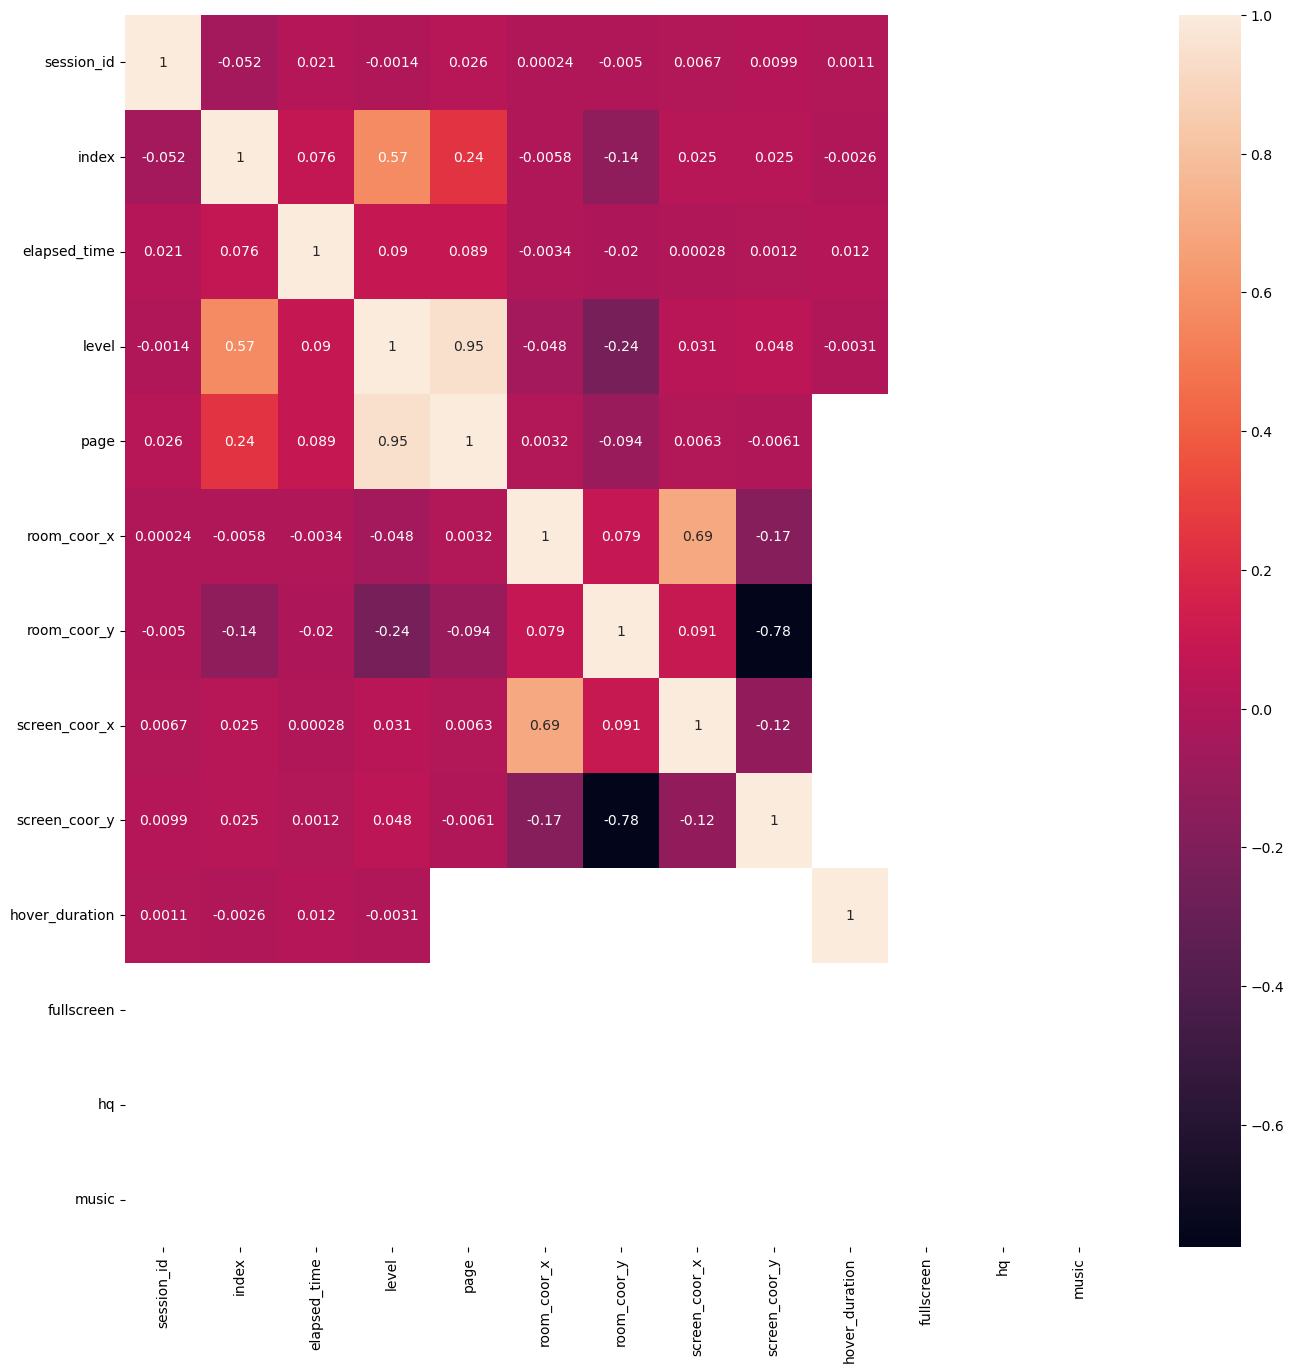

In [12]:
corr = train_df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(16,16))
sns.heatmap(corr, annot=True)
plt.show()

In [13]:
# Categorical features 
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

# Numerical features
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# define the function to create the features
def feature_engineer(train):
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [14]:
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [15]:
%%time
train = feature_engineer(train_df)
print('shape of train dataset is:',train.shape)
train.head()

shape of train dataset is: (35337, 22)
CPU times: user 17.2 s, sys: 6.02 ms, total: 17.2 s
Wall time: 17.3 s


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.000000,7.687500,...,383.00,2389.500000,49246.539458,1.230975,-1.000000,399.272451,129.295749,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.000000,-130.375000,...,379.25,899.925903,126666.129584,2.358652,-1.000000,622.081128,230.373785,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.000000,14.304688,...,378.75,969.333313,80175.676658,2.096919,-1.000000,357.219911,137.409158,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.000000,-84.062500,...,370.75,1378.750000,67372.714092,1.232616,0.000000,445.973993,156.183163,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.101562,-30.750000,...,388.00,720.384949,777382.529186,1.825923,0.863075,529.564669,234.275228,259.288856,133.345693,1990.705518


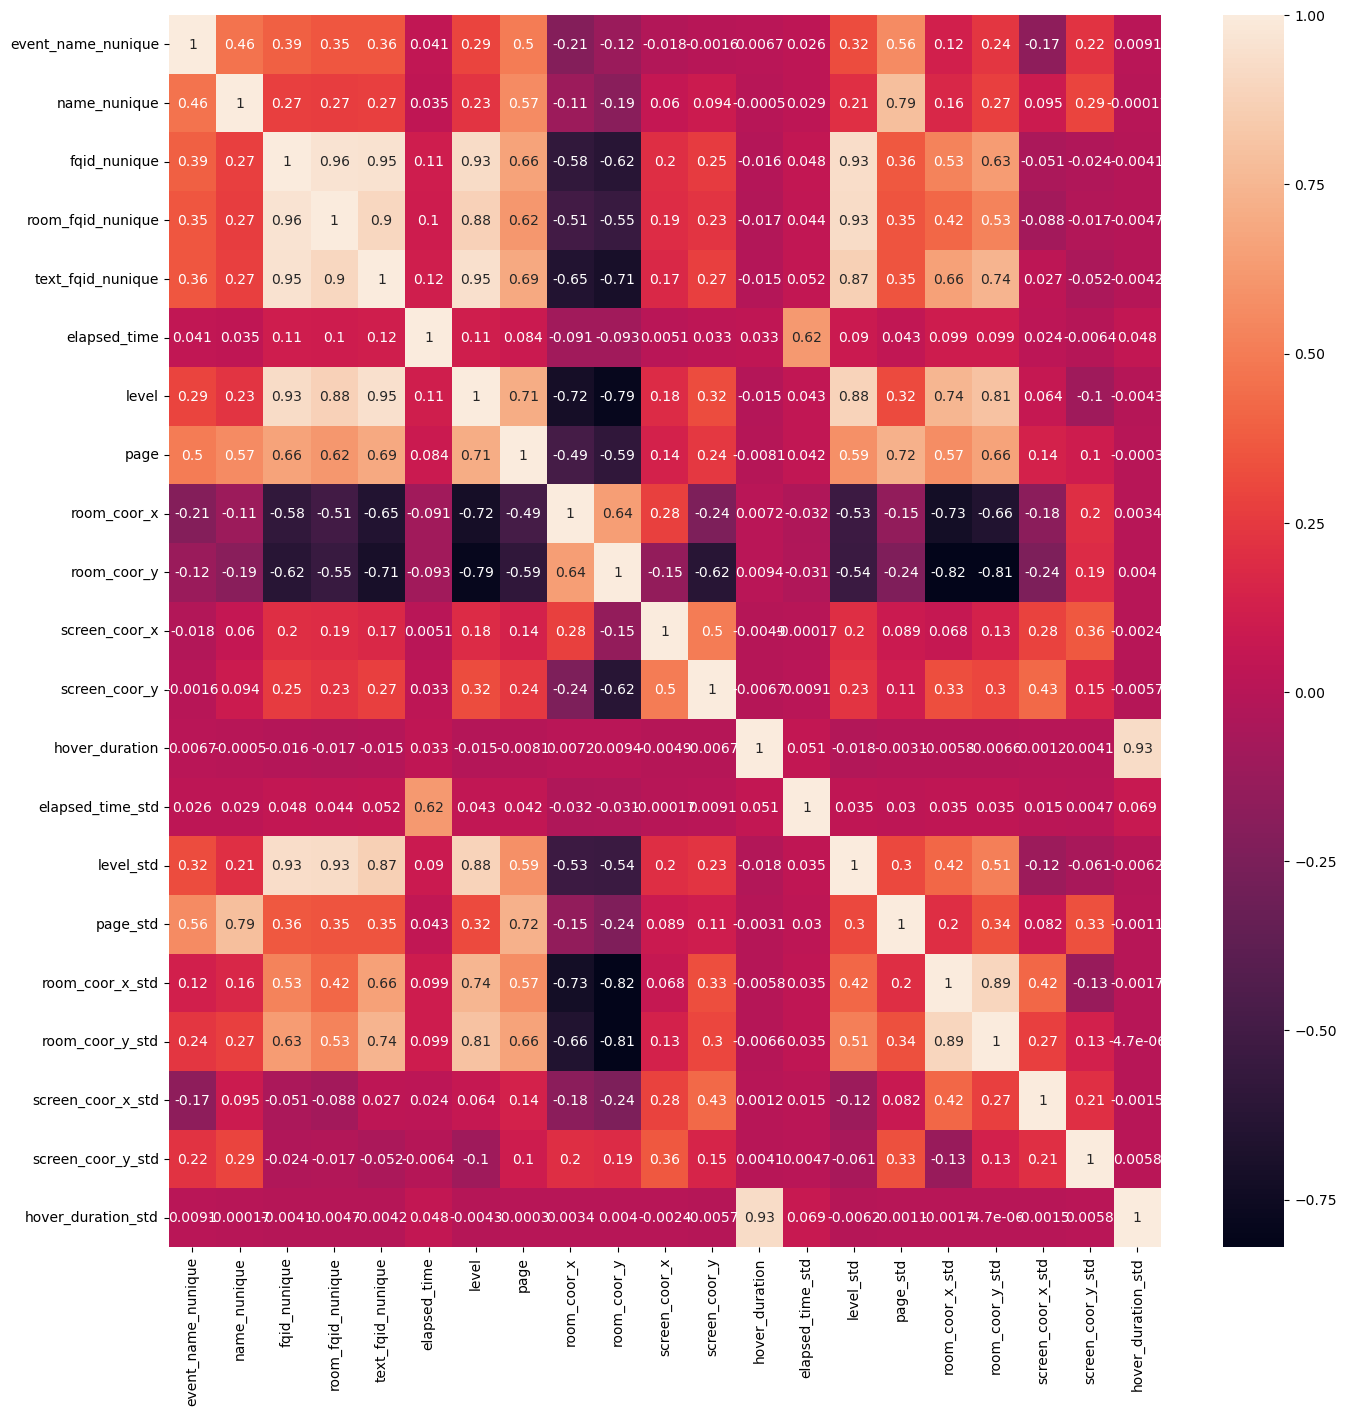

In [16]:
corr = train.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(16,16))
sns.heatmap(corr, annot=True)
plt.show()

In [17]:
for col in train.columns:
    print(col)

level_group
event_name_nunique
name_nunique
fqid_nunique
room_fqid_nunique
text_fqid_nunique
elapsed_time
level
page
room_coor_x
room_coor_y
screen_coor_x
screen_coor_y
hover_duration
elapsed_time_std
level_std
page_std
room_coor_x_std
room_coor_y_std
screen_coor_x_std
screen_coor_y_std
hover_duration_std


In [18]:
targets = train_label

## **5. Train Random Forest Model**

In [19]:
FEATURES = [c for c in train.columns if c != 'level_group'] # all features except the target
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = train.index.unique() # treat each index as a user
print('We will train with', len(ALL_USERS) ,'users info')



gkf = GroupKFold(n_splits=10)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=train, groups=train.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = train.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = train.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf = RandomForestClassifier(n_estimators=1000, max_depth=4, random_state=0, ) 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

We will train with 21 features
We will train with 11779 users info
#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 6
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 7
#########################


## **CV SCORE**

In [20]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    # q = question number
    # session = user
    # correct = 1 if correct, 0 if incorrect
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [21]:
print('CV AUC:', roc_auc_score(true, oof))

CV AUC: 0.6296539593980449


In [22]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.6,0.7025,0.0025):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.60, 0.60, 0.60, 0.61, 0.61, 0.61, 0.61, 0.62, 0.62, 0.62, 0.62, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64, 0.65, 0.65, 0.65, 0.65, 0.66, 0.66, 0.66, 0.66, 0.67, 0.67, 0.67, 0.67, 0.68, 0.68, 0.68, 0.68, 0.69, 0.69, 0.69, 0.69, 0.70, 0.70, 0.70, 

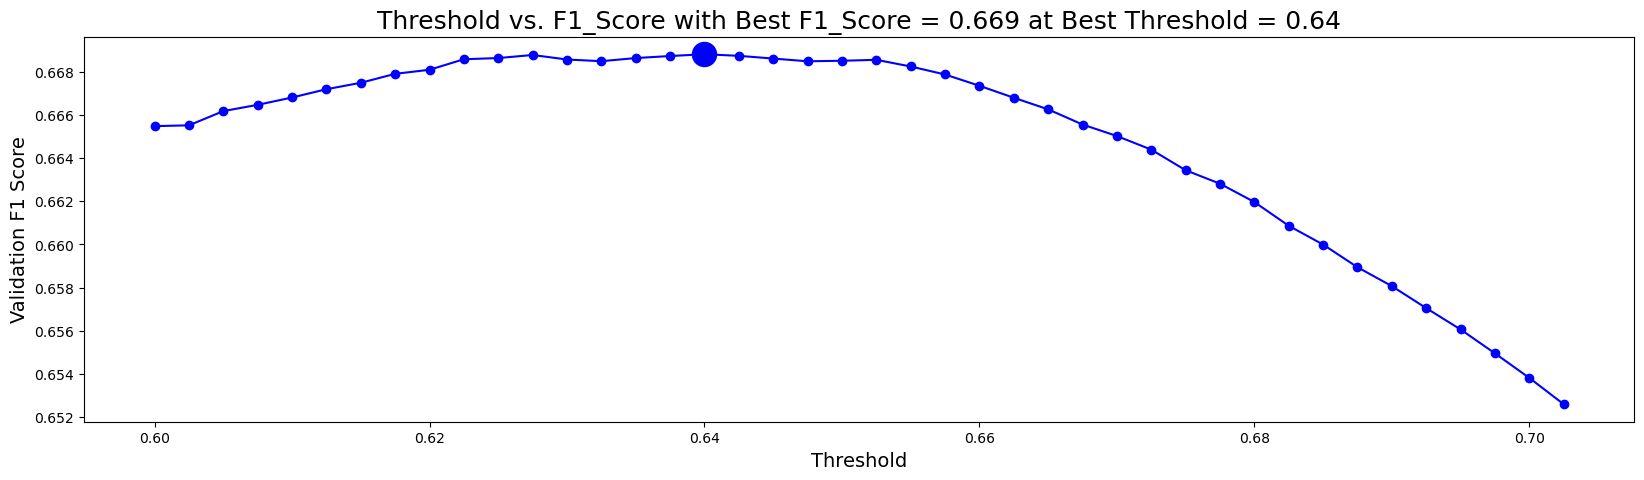

In [23]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [24]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5038148399290108
Q1: F1 = 0.4946370344945941
Q2: F1 = 0.4824465046794674
Q3: F1 = 0.5286270427379384
Q4: F1 = 0.4644678819038428
Q5: F1 = 0.5667459886762956
Q6: F1 = 0.5535098249776864
Q7: F1 = 0.5146935885720683
Q8: F1 = 0.5713007494389224
Q9: F1 = 0.3516927629521076
Q10: F1 = 0.5772560431264839
Q11: F1 = 0.4628112112723877
Q12: F1 = 0.4218044374631848
Q13: F1 = 0.5845311994590544
Q14: F1 = 0.3408136997033969
Q15: F1 = 0.4266043304918611
Q16: F1 = 0.5311574488146212
Q17: F1 = 0.48733461002785516
==> Overall F1 = 0.6688247646901744


## infer on test data

In [25]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [26]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (sample_submission, test) in iter_test:
    
    df = feature_engineer(test)
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [27]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090312143683264_q1,1
4,20090312143683264_q2,1


In [28]:
print(df.correct.mean())

0.5740740740740741
